In [46]:
import pandas as pd
df = pd.read_csv("csv/decessi_mensili.csv")
df.head()

,Data,Totale
0,2015-01-31,68514
1,2015-02-28,61031
2,2015-03-31,60418
3,2015-04-30,53591
4,2015-05-31,50678


In [47]:
df['Data'] = pd.to_datetime(df['Data'])
df.head()

,Data,Totale
0,2015-01-31,68514
1,2015-02-28,61031
2,2015-03-31,60418
3,2015-04-30,53591
4,2015-05-31,50678


In [48]:
df.set_index('Data', inplace=True)
df.head()

,Totale
Data,
2015-01-31,68514
2015-02-28,61031
2015-03-31,60418
2015-04-30,53591
2015-05-31,50678


In [49]:
ts = df.Totale
ts.head()

Data
2015-01-31    68514
2015-02-28    61031
2015-03-31    60418
2015-04-30    53591
2015-05-31    50678
Name: Totale, dtype: int64

In [50]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,31)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

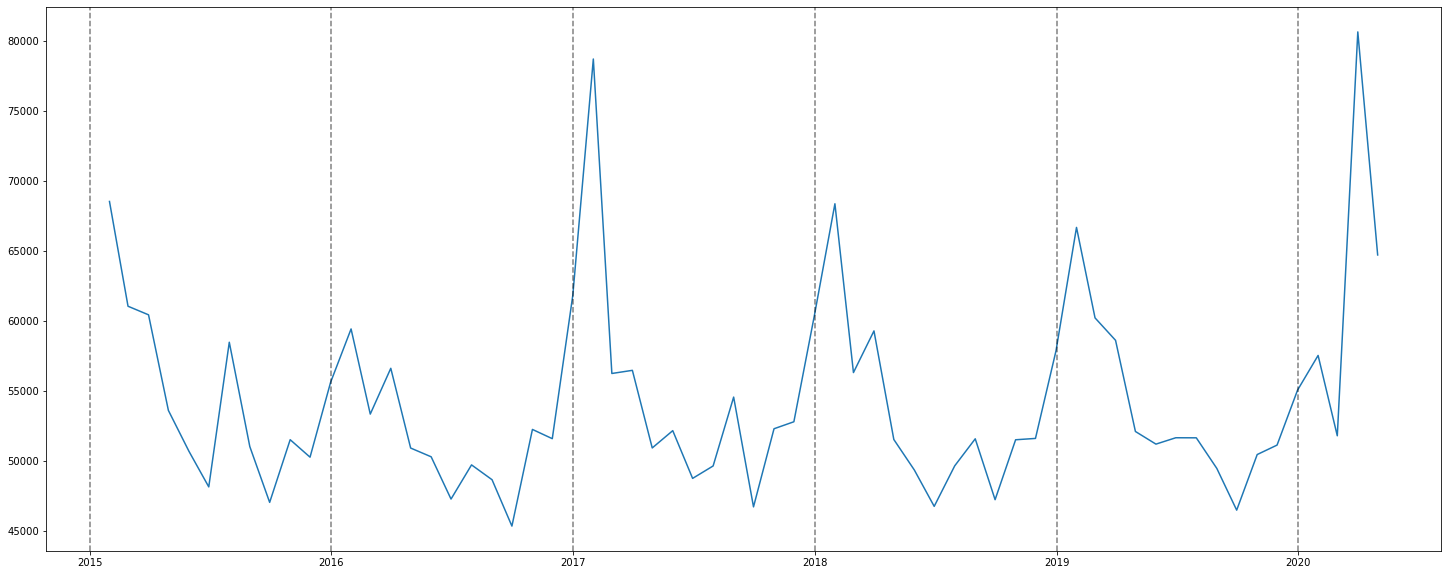

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

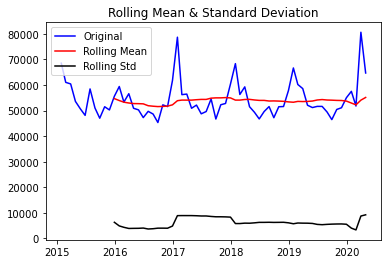

Results of Dickey-Fuller Test:
Test Statistic                 -5.040412
p-value                         0.000018
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64
X is stationary


In [52]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")
    
test_stationarity(ts)

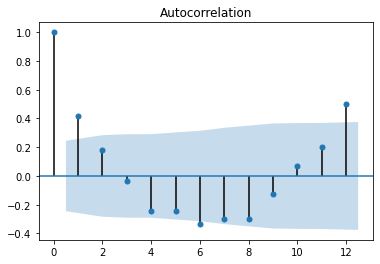

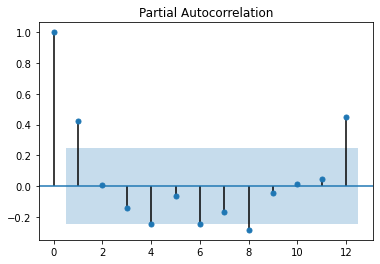

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)

plt.show()

In [54]:
from datetime import datetime
train_end = datetime (2019,10,31)
test_end = datetime (2019,12,31)

train = ts[:train_end]
test = ts[train_end + timedelta(days=1): test_end]


In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(train, order=(12, 0, 6))
model_fit = model.fit(disp=1,solver='powell')
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                 Totale   No. Observations:                   58
Model:              SARIMAX(12, 0, 6)   Log Likelihood                -559.789
Date:                Mon, 24 Aug 2020   AIC                           1157.577
Time:                        11:45:11   BIC                           1196.726
Sample:                    01-31-2015   HQIC                          1172.826
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0906      0.243      0.372      0.710      -0.386       0.567
ar.L2          0.1281      0.275      0.466      0.641      -0.410       0.666
ar.L3         -0.0276      0.363     -0.076      0.9

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


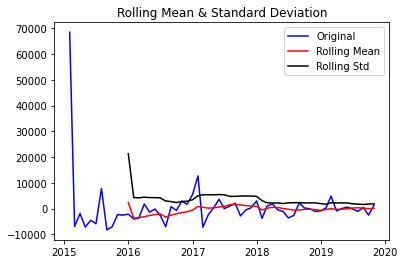

Results of Dickey-Fuller Test:
Test Statistic                -21.247573
p-value                         0.000000
#Lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64
X is stationary


In [56]:
residuals = model_fit.resid
test_stationarity(residuals)

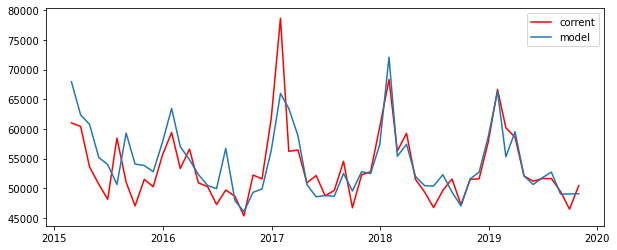

In [57]:
plt.figure(figsize=(10,4))
plt.plot(train.iloc[1:], color='red', label='corrent')
plt.plot(model_fit.fittedvalues.iloc[1:], label='model')
plt.legend()
plt.show()

In [58]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(model_fit.fittedvalues.iloc[1:], train.iloc[1:])/(np.max(train.iloc[1:])-np.min(train.iloc[1:]))
print("RMSE =" , nrmse)

RMSE = 0.11404786772937645


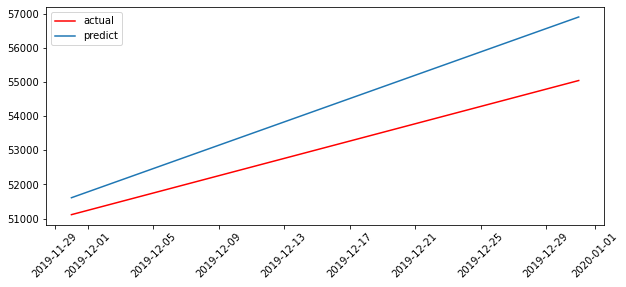

In [59]:
predictions = model_fit.forecast(steps=len(test))
plt.figure(figsize=(10,4))
plt.plot(test, label='actual', color='red')
plt.plot(predictions, label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [60]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions, test)/(np.max(test)-np.min(test))
print("RMSE =" , nrmse)

RMSE = 0.34661578727414927


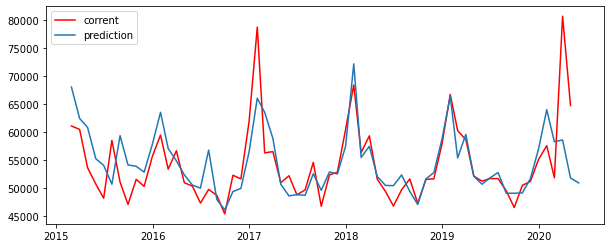

In [61]:
predictions = model_fit.predict(start=0, end=len(ts))
plt.figure(figsize=(10,4))
plt.plot(ts.iloc[1:], color='red', label='corrent')
plt.plot(predictions.iloc[1:], label='prediction')
plt.legend()
plt.show()